In [1]:
from Classes.LoadModel import BaseModel
from Classes.Predict import Prediction
from Classes.Summarize import *
from Classes.Multiclass_model import *
from tensorflow.keras.optimizers import RMSprop, SGD, Adam
from tensorflow.keras.models import Sequential, Model
from tensorflow.keras.layers import Dense, Flatten, Layer, Input, Dropout, Activation, Convolution2D, MaxPooling2D
import tensorflow as tf
from tensorflow.keras.layers import (Dense, Conv2D, MaxPool2D, Dropout, Flatten, LeakyReLU)

/home/ubuntu/anaconda3/envs/tensorflow2_latest_p37/lib/python3.7/site-packages/IPython/utils/traitlets.py:5: UserWarning: IPython.utils.traitlets has moved to a top-level traitlets package.
  warn("IPython.utils.traitlets has moved to a top-level traitlets package.")


In [2]:
# Start images processing and dataframe splitting
Multi = Multiclass_Model(IND_FILE)
trainer = Train(IND_FILE, IMAGE_PATH)

In [3]:
print('Reading File...')
print(f'Preparing data.. \nCreating Train, Test...')

label_list = ['Brown_Hair','Blond_Hair', 'Black_Hair','Bald', 'Gray_Hair']
train, test = Multi.create_dataframe_multi(label_list, 4500)
print('Done!')

Reading File...
Preparing data.. 
Creating Train, Test...
Assertions Passed! Sets  Are of image files W/O Duplication
Done!


In [4]:
# Split Train, Validation and Test Sets
print(f'\nRunning data generator...')
model_name = 'MobileNetV2'
train_data, valid_data, test_data = Multi.generator_splitter_multi(model_name, train, test, IMAGE_PATH)


Running data generator...
Found 13804 validated image filenames belonging to 5 classes.
Found 3450 validated image filenames belonging to 5 classes.
Found 4494 validated image filenames.


In [5]:
# Loading Base Model
print(f'\n\nLoading Model...')
print('Pick a Model: vgg19, MobileNetV2, vggface, facenet, emotion, age, gender, race')
label_name = 'Hair_color'
model_file = os.path.join('Weights/', model_name + '_' + label_name + '.h5')
json_path = os.path.join('json/', model_name + '_' + label_name + '.json')
epoch = 100



Loading Model...
Pick a Model: vgg19, MobileNetV2, vggface, facenet, emotion, age, gender, race


In [6]:
# Training
print(f'\nTraining Start...')
basemodel = BaseModel(model_name)

base_model = basemodel.load_model()
base_model.trainable = False


Training Start...
Input_shape:	(None, 224, 224, 3)
Output_shape:	(None, 7, 7, 1280)
Params:	2257984
Layer:	155


Model: "mobilenetv2_1.00_224"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_1 (InputLayer)            [(None, 224, 224, 3) 0                                            
__________________________________________________________________________________________________
Conv1_pad (ZeroPadding2D)       (None, 225, 225, 3)  0           input_1[0][0]                    
__________________________________________________________________________________________________
Conv1 (Conv2D)                  (None, 112, 112, 32) 864         Conv1_pad[0][0]                  
__________________________________________________________________________________________________
bn_Conv1 (BatchNormalization)   (None, 112, 112, 32) 128        

In [7]:
# Trainable classification head
model = tf.keras.Sequential([
    base_model,
    Flatten(),
    Dense(32),
    LeakyReLU(0.001),
    Dropout(0.5),
    Dense(16),
    LeakyReLU(0.001),
    Dense(5, activation='softmax')])

history, model = trainer.start_train(model, model_file, train_data, valid_data, epoch, multi=True,
                                     callback=None,
                                     optimize=None)
print('Loading best weights...')
model.load_weights(model_file)
print('Done!')

# Saving History
with open(json_path, 'w') as f:
    json.dump(history.history, f)
history = json.load(open(json_path))

Epoch 1/100
215/215 [==============================] - ETA: 0s - loss: 1.4712 - accuracy: 0.3661
Epoch 00001: val_loss improved from inf to 1.12681, saving model to Weights/MobileNetV2_Hair_color.h5
215/215 [==============================] - 45s 209ms/step - loss: 1.4712 - accuracy: 0.3661 - val_loss: 1.1268 - val_accuracy: 0.5336
Epoch 2/100
215/215 [==============================] - ETA: 0s - loss: 1.2311 - accuracy: 0.4797
Epoch 00002: val_loss improved from 1.12681 to 1.03290, saving model to Weights/MobileNetV2_Hair_color.h5
215/215 [==============================] - 37s 171ms/step - loss: 1.2311 - accuracy: 0.4797 - val_loss: 1.0329 - val_accuracy: 0.5938
Epoch 3/100
215/215 [==============================] - ETA: 0s - loss: 1.1337 - accuracy: 0.5321
Epoch 00003: val_loss improved from 1.03290 to 1.00886, saving model to Weights/MobileNetV2_Hair_color.h5
215/215 [==============================] - 36s 170ms/step - loss: 1.1337 - accuracy: 0.5321 - val_loss: 1.0089 - val_accuracy: 

In [8]:
# Evaluate the network on valid data
Prediction.evaluate_model(model, valid_data)

Evaluating the network ...
54/54 [==============================] - 7s 139ms/step - loss: 0.9058 - accuracy: 0.6481
Validation Loss:	0.906
Validation Acc.:	0.648


In [9]:
labels = (train_data.class_indices)
labels

{'Bald': 0, 'Black_Hair': 1, 'Blond_Hair': 2, 'Brown_Hair': 3, 'Gray_Hair': 4}

In [10]:
# Predict on test data
y_pred = Prediction.test_prediction(model, test_data, train_data)

Starting prediction...
Done!


Confusion Matrix ...
     0    1    2    3    4
0  466   37   13   19  359
1   18  643   21  158   51
2   11   19  582  227   58
3    8  125  127  556   82
4  144   51   54   56  595


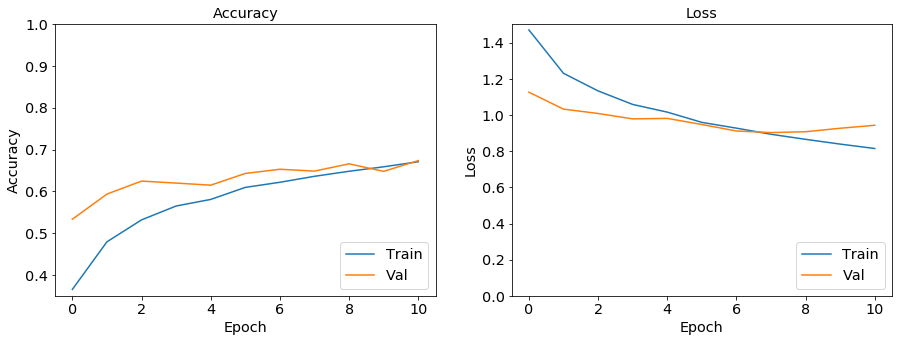

Classification Report ...
{'Bald': {'precision': 0.7202472952086554, 'recall': 0.5212527964205816, 'f1-score': 0.6048020765736535, 'support': 894}, 'Black_Hair': {'precision': 0.7348571428571429, 'recall': 0.7216610549943884, 'f1-score': 0.7281993204983014, 'support': 891}, 'Blond_Hair': {'precision': 0.7302383939774153, 'recall': 0.6488294314381271, 'f1-score': 0.6871310507674144, 'support': 897}, 'Brown_Hair': {'precision': 0.547244094488189, 'recall': 0.6191536748329621, 'f1-score': 0.58098223615465, 'support': 898}, 'Gray_Hair': {'precision': 0.519650655021834, 'recall': 0.6611111111111111, 'f1-score': 0.5819070904645477, 'support': 900}, 'accuracy': 0.634375, 'macro avg': {'precision': 0.6504475163106472, 'recall': 0.634401613759434, 'f1-score': 0.6366043548917134, 'support': 4480}, 'weighted avg': {'precision': 0.6501771031183121, 'recall': 0.634375, 'f1-score': 0.6364539359473599, 'support': 4480}}


In [11]:
# plot
top = min(len(test['label']), len(y_pred))
metrics = Metrics(history, epoch, test['label'][:top].tolist(), y_pred[:top], model_name, label_name)
metrics.confusion_matrix()
metrics.acc_loss_graph()
metrics.classification_report()